In [4]:
from keras.models import Sequential,load_model
from keras.layers import Conv2D,Activation, MaxPooling2D,Dense,Flatten
from keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from sklearn.metrics import accuracy_score,roc_curve,confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt_False_Positive_vs_True_Positive
from tensorflow.keras.callbacks import EarlyStopping



2025-06-02 19:15:15.473402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748891715.653645      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748891715.703816      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
def Build_CNN_Model():
    
    # -------------------------------------------------------------------------
    #                        Build CNN Model 
    # -------------------------------------------------------------------------
    model = Sequential()
    
    #  First Block of CNN
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(128, 128, 3)))  
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    
    #  Second Block of CNN
    model.add(Conv2D(64, (3, 3),  padding='same'))  
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))

    #  Third Block of CNN
    model.add(Conv2D(128, (3, 3), padding='same'))  
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))  

    
    #  Flatten and Fully Connected Layer
    model.add(Flatten())
    model.add(Dense(1000))
    model.add(Activation('relu'))
     
    model.add(Dense(1)) 
    model.add(Activation('sigmoid'))
        
    #  Display model
    model.summary()
    
	# compile model
    opt = SGD(learning_rate=0.001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [9]:
def Train_CNN_Model(model):
    # -------------------------------------------------------------------------
    #                        Train CNN Model 
    # -------------------------------------------------------------------------
    
    data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/'
    batch_size = 32
    image_size = (128, 128)
    
    # Create ImageDataGenerator with validation split
    datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        featurewise_center=True,
        featurewise_std_normalization=True,
        validation_split=0.1
    )
    
    # Prepare iterators
    train_it = datagen.flow_from_directory(
        data_dir,
        target_size=image_size,
        batch_size=batch_size,
        classes=('NORMAL', 'PNEUMONIA'),
        class_mode='binary',
        subset='training',
        seed=123
    )

    valid_it = datagen.flow_from_directory(
        data_dir,
        target_size=image_size,
        batch_size=batch_size,
        classes=('NORMAL', 'PNEUMONIA'),
        class_mode='binary',
        subset='validation',
        seed=123
    )

    # Train the model
    epochs = 100
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    print("Training started...")
    history = model.fit(
        train_it,
        steps_per_epoch=len(train_it),
        validation_data=valid_it,
        validation_steps=len(valid_it),
        epochs=epochs,
        verbose=1,
        callbacks = [early_stopping]
    )
    
    # Plot Accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    # Plot Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Save the trained model
    model.save('medical_diagnosis_cnn_model.h5')

In [6]:
def Evaluate_CNN_Model():
    # -------------------------------------------------------------------------
    #                        Evaluate CNN Model 
    # -------------------------------------------------------------------------
    
    # load model
    model = load_model('medical_diagnosis_cnn_model.h5')
    
    # load test data
    batch_size=32
    test_datagen = ImageDataGenerator(
                                     rescale=1.0/255.0,
                                     featurewise_center= True,
                                     featurewise_std_normalization = True)
    
    test_it = test_datagen.flow_from_directory('/kaggle/input/chest-xray-pneumonia/chest_xray/test/',classes =('NORMAL','PNEUMONIA'), 
                                               shuffle=False,batch_size=batch_size, target_size=(128, 128))
    
    y_true = test_it.classes;

    y_pred = model.predict(test_it, steps=len(test_it), verbose=1)

    
    y_pred_prob = y_pred[:, 0]

     
    y_pred_binary =  y_pred_prob > 0.5
   
    #Confution Matrix    
    print('\nConfusion Matrix\n -------------------------')    
    print(confusion_matrix(y_true,y_pred_binary));
    
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_true, y_pred_binary)
    print('Accuracy: %f' % accuracy)
    
    
    # precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred_binary)
    print('Precision: %f' % precision)
    
    # recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred_binary)
    print('Recall: %f' % recall)
    
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_pred_binary)
    print('F1 score: %f' % f1)    
       
    # ROC AUC
    auc = roc_auc_score(y_true, y_pred_prob)
    print('ROC AUC: %f' % auc)
    
    
    # calculate roc curves
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
        
    # plot the roc curve for the model
    plt.figure()
    plt_False_Positive_vs_True_Positive.plot(fpr, tpr, linestyle='--', label='')
    
    # axis labels
    plt_False_Positive_vs_True_Positive.xlabel('False Positive Rate')
    plt_False_Positive_vs_True_Positive.ylabel('True Positive Rate')
       
    # show the legend
    plt_False_Positive_vs_True_Positive.legend()
    # show the plot
    plt_False_Positive_vs_True_Positive.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1000)                │      32,769,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │           1,001 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,863,249 (125.36 MB)

 Trainable params: 32,863,249 (125.36 MB)

 Non-trainable params: 0 (0.00 B)

Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Training started...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1273: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 51s 332ms/step - accuracy: 0.6871 - loss: 0.6122 - val_accuracy: 0.7428 - val_loss: 0.5664
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 46s 312ms/step - accuracy: 0.7314 - loss: 0.5735 - val_accuracy: 0.7428 - val_loss: 0.5522
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 46s 312ms/step - accuracy: 0.7373 - loss: 0.5512 - val_accuracy: 0.7428 - val_loss: 0.5351
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 46s 316ms/step - accuracy: 0.7457 - loss: 0.5231 - val_accuracy: 0.7428 - val_loss: 0.5131
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 47s 320ms/step - accuracy: 0.7376 - loss: 0.4992 - val_accuracy: 0.7447 - val_loss: 0.4818
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 47s 318ms/step - accuracy: 0.7498 - loss: 0.4570 - val_accuracy: 0.7639 - val_loss: 0.4387
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 46s 315ms/step - accuracy: 0.8160 - loss: 0.3944 - val_accuracy: 0.8599 - val_loss: 0.4151
Epoch 8/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 47s 322ms/step - accuracy: 0.8816 -

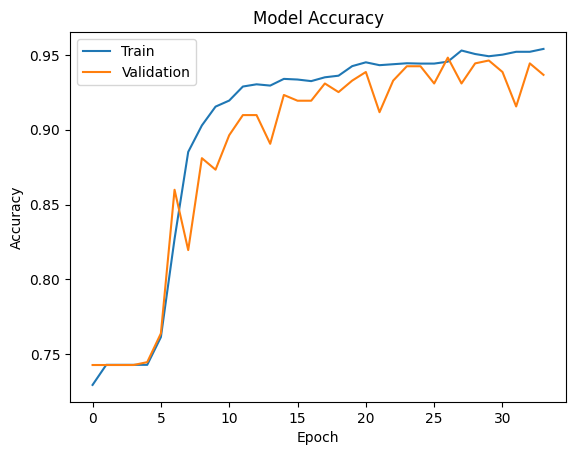

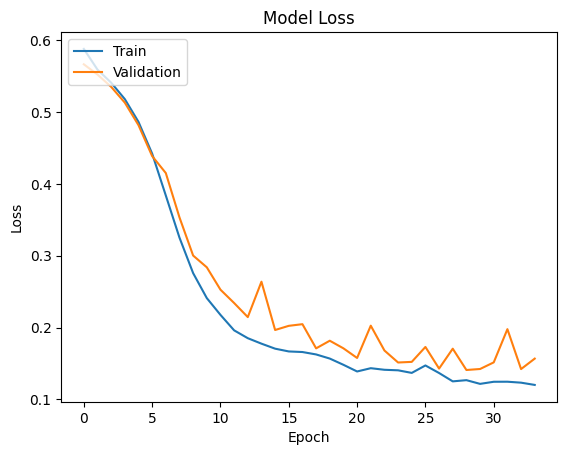

In [10]:
model = Build_CNN_Model()

Train_CNN_Model(model)
    

Found 624 images belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step

Confusion Matrix
 -------------------------
[[101 133]
 [  7 383]]
Accuracy: 0.775641
Precision: 0.742248
Recall: 0.982051
F1 score: 0.845475
ROC AUC: 0.920381


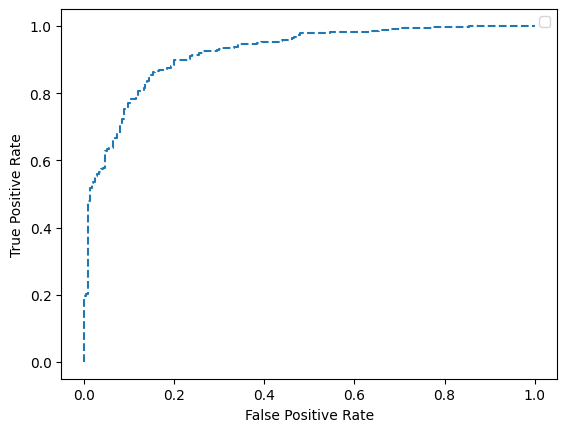

In [11]:
Evaluate_CNN_Model()

In [7]:
def Train_CNN_Model(model):
    # -------------------------------------------------------------------------
    #                        Train CNN Model 
    # -------------------------------------------------------------------------
    
    data_dir = '/kaggle/working/train_gan_150_new/'
    batch_size = 32
    image_size = (128, 128)
    
    # Create ImageDataGenerator with validation split
    datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        featurewise_center=True,
        featurewise_std_normalization=True,
        validation_split=0.1
    )
    
    # Prepare iterators
    train_it = datagen.flow_from_directory(
        data_dir,
        target_size=image_size,
        batch_size=batch_size,
        classes=('NORMAL', 'PNEUMONIA'),
        class_mode='binary',
        subset='training',
        seed=123
    )

    valid_it = datagen.flow_from_directory(
        data_dir,
        target_size=image_size,
        batch_size=batch_size,
        classes=('NORMAL', 'PNEUMONIA'),
        class_mode='binary',
        subset='validation',
        seed=123
    )

    # Train the model
    epochs = 100
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    print("Training started...")
    history = model.fit(
        train_it,
        steps_per_epoch=len(train_it),
        validation_data=valid_it,
        validation_steps=len(valid_it),
        epochs=epochs,
        verbose=1,
        callbacks = [early_stopping]
    )
    
    # Plot Accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    # Plot Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Save the trained model
    model.save('medical_diagnosis_cnn_model.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1748891747.949112      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1000)                │      32,769,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,001 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,863,249 (125.36 MB)

 Trainable params: 32,863,249 (125.36 MB)

 Non-trainable params: 0 (0.00 B)

Found 4830 images belonging to 2 classes.
Found 536 images belonging to 2 classes.
Training started...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1273: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/100


I0000 00:00:1748891751.526223      96 service.cc:148] XLA service 0x7f2fdc004ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748891751.527145      96 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748891751.755491      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/151 ━━━━━━━━━━━━━━━━━━━━ 9:48 4s/step - accuracy: 0.6875 - loss: 0.6779

I0000 00:00:1748891754.264833      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


151/151 ━━━━━━━━━━━━━━━━━━━━ 51s 311ms/step - accuracy: 0.7230 - loss: 0.6246 - val_accuracy: 0.7220 - val_loss: 0.6091
Epoch 2/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 42s 280ms/step - accuracy: 0.7247 - loss: 0.5853 - val_accuracy: 0.7220 - val_loss: 0.5987
Epoch 3/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 42s 281ms/step - accuracy: 0.7312 - loss: 0.5660 - val_accuracy: 0.7220 - val_loss: 0.5859
Epoch 4/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 43s 284ms/step - accuracy: 0.7222 - loss: 0.5566 - val_accuracy: 0.7220 - val_loss: 0.5645
Epoch 5/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 42s 281ms/step - accuracy: 0.7317 - loss: 0.5239 - val_accuracy: 0.7220 - val_loss: 0.5395
Epoch 6/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 42s 280ms/step - accuracy: 0.7185 - loss: 0.5012 - val_accuracy: 0.7201 - val_loss: 0.4876
Epoch 7/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 43s 281ms/step - accuracy: 0.7714 - loss: 0.4386 - val_accuracy: 0.7743 - val_loss: 0.4250
Epoch 8/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 42s 280ms/step - accuracy: 0.8572 - loss: 0.371

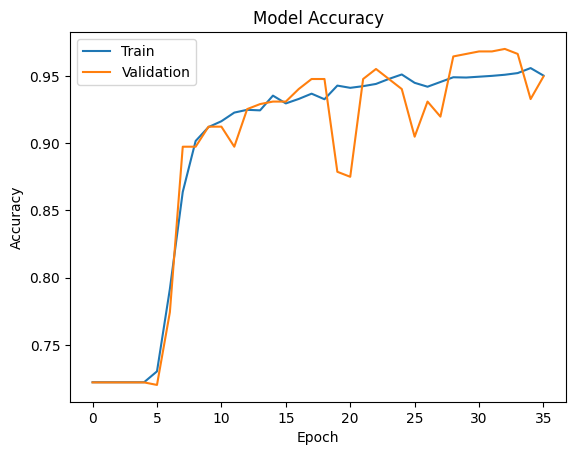

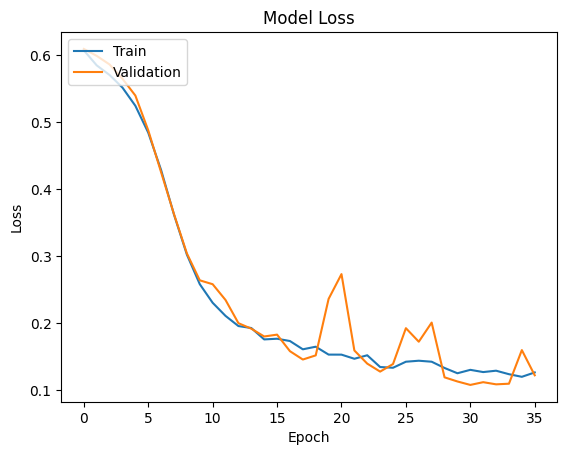

Found 624 images belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 363ms/step

Confusion Matrix
 -------------------------
[[103 131]
 [  7 383]]
Accuracy: 0.778846
Precision: 0.745136
Recall: 0.982051
F1 score: 0.847345
ROC AUC: 0.917532


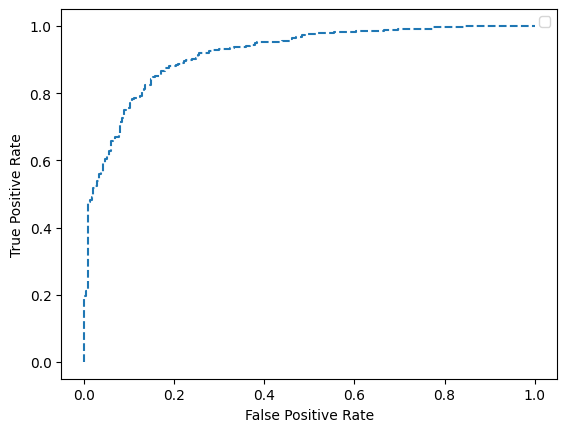

In [8]:
model1 = Build_CNN_Model()

Train_CNN_Model(model1)
Evaluate_CNN_Model()

In [67]:
def Train_CNN_Model(model):
    # -------------------------------------------------------------------------
    #                        Train CNN Model 
    # -------------------------------------------------------------------------
    
    data_dir = '/kaggle/working/train_gan_300_new/'
    batch_size = 32
    image_size = (128, 128)
    
    # Create ImageDataGenerator with validation split
    datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        featurewise_center=True,
        featurewise_std_normalization=True,
        validation_split=0.1
    )
    
    # Prepare iterators
    train_it = datagen.flow_from_directory(
        data_dir,
        target_size=image_size,
        batch_size=batch_size,
        classes=('NORMAL', 'PNEUMONIA'),
        class_mode='binary',
        subset='training',
        seed=123
    )

    valid_it = datagen.flow_from_directory(
        data_dir,
        target_size=image_size,
        batch_size=batch_size,
        classes=('NORMAL', 'PNEUMONIA'),
        class_mode='binary',
        subset='validation',
        seed=123
    )

    # Train the model
    epochs = 100
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    print("Training started...")
    history = model.fit(
        train_it,
        steps_per_epoch=len(train_it),
        validation_data=valid_it,
        validation_steps=len(valid_it),
        epochs=epochs,
        verbose=1,
        callbacks = [early_stopping]
    )
    
    # Plot Accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    # Plot Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Save the trained model
    model.save('medical_diagnosis_cnn_model.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_55 (Activation)           │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_56 (Activation)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_57 (Activation)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1000)                │      32,769,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_58 (Activation)           │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │           1,001 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_59 (Activation)           │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,863,249 (125.36 MB)

 Trainable params: 32,863,249 (125.36 MB)

 Non-trainable params: 0 (0.00 B)

Found 4965 images belonging to 2 classes.
Found 551 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1273: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Training started...
Epoch 1/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 39s 244ms/step - accuracy: 0.7022 - loss: 0.6269 - val_accuracy: 0.7024 - val_loss: 0.6054
Epoch 2/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 36s 233ms/step - accuracy: 0.6968 - loss: 0.5912 - val_accuracy: 0.7024 - val_loss: 0.5754
Epoch 3/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 37s 235ms/step - accuracy: 0.7119 - loss: 0.5494 - val_accuracy: 0.7024 - val_loss: 0.5350
Epoch 4/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 37s 235ms/step - accuracy: 0.7040 - loss: 0.5185 - val_accuracy: 0.7060 - val_loss: 0.4812
Epoch 5/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 37s 236ms/step - accuracy: 0.7861 - loss: 0.4424 - val_accuracy: 0.8221 - val_loss: 0.3981
Epoch 6/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 37s 235ms/step - accuracy: 0.8721 - loss: 0.3725 - val_accuracy: 0.9074 - val_loss: 0.3251
Epoch 7/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 37s 234ms/step - accuracy: 0.8936 - loss: 0.3102 - val_accuracy: 0.9165 - val_loss: 0.2759
Epoch 8/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 36s 234ms/step 

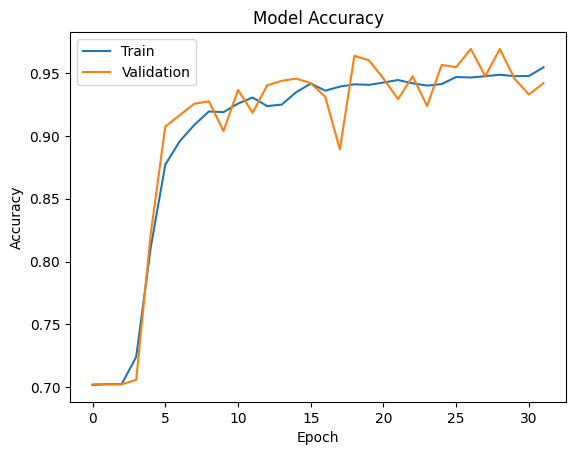

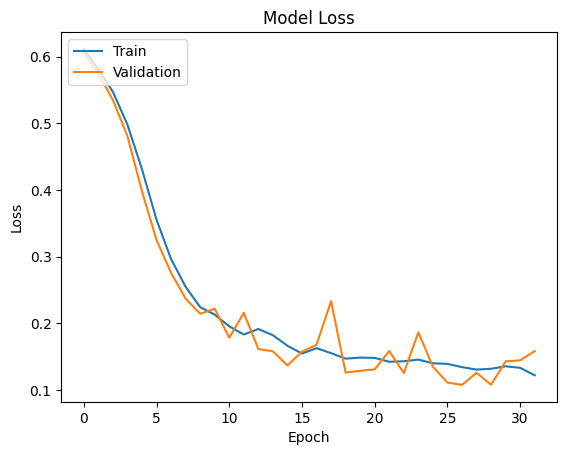

Found 624 images belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step

Confusion Matrix
 -------------------------
[[122 112]
 [ 11 379]]
Accuracy: 0.802885
Precision: 0.771894
Recall: 0.971795
F1 score: 0.860386
ROC AUC: 0.918727


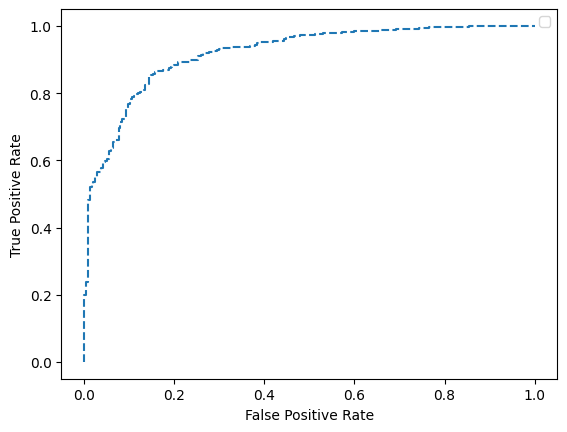

In [68]:
model2 = Build_CNN_Model()

Train_CNN_Model(model2)
Evaluate_CNN_Model()

In [7]:
def Train_CNN_Model(model):
    # -------------------------------------------------------------------------
    #                        Train CNN Model 
    # -------------------------------------------------------------------------
    
    data_dir = '/kaggle/working/train_gan_600_new/'
    batch_size = 32
    image_size = (128, 128)
    
    # Create ImageDataGenerator with validation split
    datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        featurewise_center=True,
        featurewise_std_normalization=True,
        validation_split=0.1
    )
    
    # Prepare iterators
    train_it = datagen.flow_from_directory(
        data_dir,
        target_size=image_size,
        batch_size=batch_size,
        classes=('NORMAL', 'PNEUMONIA'),
        class_mode='binary',
        subset='training',
        seed=123
    )

    valid_it = datagen.flow_from_directory(
        data_dir,
        target_size=image_size,
        batch_size=batch_size,
        classes=('NORMAL', 'PNEUMONIA'),
        class_mode='binary',
        subset='validation',
        seed=123
    )

    # Train the model
    epochs = 100
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    print("Training started...")
    history = model.fit(
        train_it,
        steps_per_epoch=len(train_it),
        validation_data=valid_it,
        validation_steps=len(valid_it),
        epochs=epochs,
        verbose=1,
        callbacks = [early_stopping]
    )
    
    # Plot Accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    # Plot Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Save the trained model
    model.save('medical_diagnosis_cnn_model.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1748885433.652843      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1000)                │      32,769,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,001 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,863,249 (125.36 MB)

 Trainable params: 32,863,249 (125.36 MB)

 Non-trainable params: 0 (0.00 B)

Found 5235 images belonging to 2 classes.
Found 581 images belonging to 2 classes.
Training started...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1273: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/100


I0000 00:00:1748885436.492998      96 service.cc:148] XLA service 0x7b34e80075d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748885436.493673      96 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748885436.721470      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/164 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.4514 - loss: 0.6969

I0000 00:00:1748885439.030143      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


164/164 ━━━━━━━━━━━━━━━━━━━━ 44s 246ms/step - accuracy: 0.6365 - loss: 0.6670 - val_accuracy: 0.6661 - val_loss: 0.6469
Epoch 2/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 37s 225ms/step - accuracy: 0.6580 - loss: 0.6375 - val_accuracy: 0.6661 - val_loss: 0.6304
Epoch 3/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 37s 225ms/step - accuracy: 0.6750 - loss: 0.6116 - val_accuracy: 0.6661 - val_loss: 0.6117
Epoch 4/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 37s 227ms/step - accuracy: 0.6662 - loss: 0.5972 - val_accuracy: 0.6661 - val_loss: 0.5872
Epoch 5/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 37s 226ms/step - accuracy: 0.6683 - loss: 0.5692 - val_accuracy: 0.7022 - val_loss: 0.5406
Epoch 6/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 37s 227ms/step - accuracy: 0.7242 - loss: 0.5216 - val_accuracy: 0.7057 - val_loss: 0.4767
Epoch 7/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 37s 225ms/step - accuracy: 0.8153 - loss: 0.4592 - val_accuracy: 0.9002 - val_loss: 0.3865
Epoch 8/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 37s 226ms/step - accuracy: 0.8879 - loss: 0.374

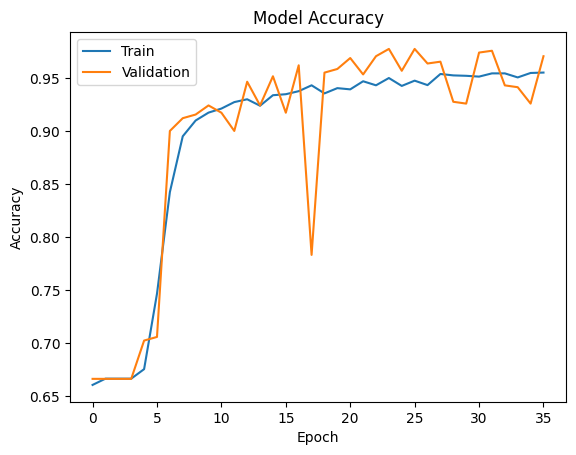

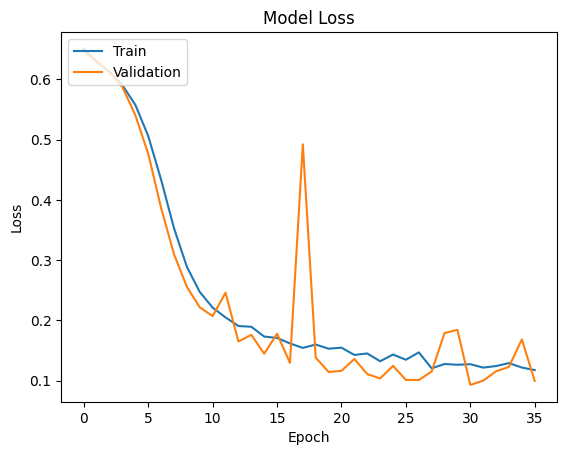

Found 624 images belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 892ms/step

Confusion Matrix
 -------------------------
[[100 134]
 [  7 383]]
Accuracy: 0.774038
Precision: 0.740812
Recall: 0.982051
F1 score: 0.844542
ROC AUC: 0.917631


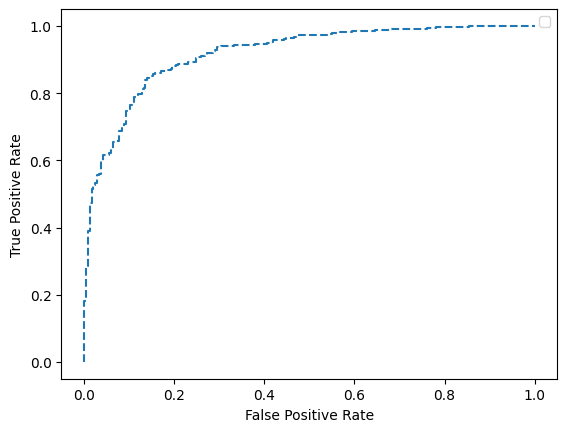

In [8]:
model3 = Build_CNN_Model()

Train_CNN_Model(model3)
Evaluate_CNN_Model()

In [1]:
import os
import shutil
from PIL import Image

# Cấu hình
gan_src_dir = '/kaggle/input/pictop150/kaggle/working/fake_top150_png'  # thư mục ảnh GAN gốc
train_normal_dir = './kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL'  # thư mục ảnh NORMAL
gan_output_dir = './gan_resized_full_top150'                                          # nơi chứa toàn bộ ảnh GAN đã resize

# Tạo thư mục đầu ra
os.makedirs(gan_output_dir, exist_ok=True)

# Danh sách ảnh GAN
gan_images = sorted([f for f in os.listdir(gan_src_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

print(f"[•] Tổng cộng {len(gan_images)} ảnh GAN sẽ được resize về 128x128...")

# Resize ảnh
for fname in gan_images:
    src_path = os.path.join(gan_src_dir, fname)
    dst_path = os.path.join(gan_output_dir, fname)

    try:
        img = Image.open(src_path).convert('RGB')
        img = img.resize((128, 128), Image.BICUBIC)
        img.save(dst_path)
    except Exception as e:
        print(f"[!] Lỗi ảnh {fname}: {e}")

# Tạo thư mục con trong NORMAL để lưu ảnh GAN
final_target_dir = os.path.join(train_normal_dir, 'gan_full')
os.makedirs(final_target_dir, exist_ok=True)

# Chép ảnh đã resize vào thư mục huấn luyện
copied = 0
for fname in os.listdir(gan_output_dir):
    try:
        shutil.copy(os.path.join(gan_output_dir, fname), os.path.join(final_target_dir, fname))
        copied += 1
    except Exception as e:
        print(f"[!] Lỗi khi sao chép {fname}: {e}")

print(f"\n✅ Đã resize và chép {copied}/{len(gan_images)} ảnh GAN vào thư mục NORMAL/gan_full.")


[•] Tổng cộng 150 ảnh GAN sẽ được resize về 128x128...

✅ Đã resize và chép 150/150 ảnh GAN vào thư mục NORMAL/gan_full.


In [2]:
import os
import shutil

# Thư mục ảnh NORMAL gốc
normal_original_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL'

# Thư mục ảnh GAN đã resize (toàn bộ)
gan_resized_dir = '//kaggle/working/gan_resized_full_top150'  # hoặc thư mục bạn đã resize 128x128

# Thư mục output chứa bộ dữ liệu gộp
output_dir = './combined_normal_gan_top150'
os.makedirs(output_dir, exist_ok=True)

# 🟢 Copy toàn bộ ảnh NORMAL
normal_images = [f for f in os.listdir(normal_original_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
for fname in normal_images:
    src = os.path.join(normal_original_dir, fname)
    dst = os.path.join(output_dir, fname)
    shutil.copy(src, dst)

# 🟣 Copy toàn bộ ảnh GAN (và đổi tên tránh trùng)
gan_images = [f for f in os.listdir(gan_resized_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
for idx, fname in enumerate(gan_images):
    src = os.path.join(gan_resized_dir, fname)
    new_name = f'GAN_full_{idx:04d}.jpg'
    dst = os.path.join(output_dir, new_name)
    shutil.copy(src, dst)

print(f"\n✅ Đã gộp xong: {len(normal_images)} NORMAL + {len(gan_images)} GAN ➜ {len(os.listdir(output_dir))} ảnh.")



✅ Đã gộp xong: 1341 NORMAL + 150 GAN ➜ 1491 ảnh.


In [3]:
import os
import shutil

# Thư mục ảnh NORMAL mới đã gộp
normal_new = '/kaggle/working/combined_normal_gan_top150'

# Thư mục ảnh PNEUMONIA gốc
pneumonia_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA'

# Tạo thư mục train mới
train_new_dir = './train_gan_150_new'
os.makedirs(os.path.join(train_new_dir, 'NORMAL'), exist_ok=True)
os.makedirs(os.path.join(train_new_dir, 'PNEUMONIA'), exist_ok=True)

# Copy ảnh NORMAL mới vào
for fname in os.listdir(normal_new):
    shutil.copy(os.path.join(normal_new, fname), os.path.join(train_new_dir, 'NORMAL', fname))

# Copy ảnh PNEUMONIA gốc vào
for fname in os.listdir(pneumonia_dir):
    shutil.copy(os.path.join(pneumonia_dir, fname), os.path.join(train_new_dir, 'PNEUMONIA', fname))

print("✅ Đã tạo lại thư mục train_gan20 với NORMAL + PNEUMONIA.")


✅ Đã tạo lại thư mục train_gan20 với NORMAL + PNEUMONIA.
